Yunyi Zhang<br>
USC ID: 7518630167

In [242]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import hamming_loss as sk_hamming_loss
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

In [156]:
data = pd.read_csv('../HW7Data/Frogs_MFCCs.csv')

le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

data['Family_Encoded'] = le_family.fit_transform(data['Family'])
data['Genus_Encoded'] = le_family.fit_transform(data['Genus'])
data['Species_Encoded'] = le_family.fit_transform(data['Species'])

data.drop(columns=['Family', 'Genus', 'Species'], inplace=True)
data.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,RecordID,Family_Encoded,Genus_Encoded,Species_Encoded
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,1,3,0,0
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,1,3,0,0
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,1,3,0,0
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,1,3,0,0
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,1,3,0,0


In [157]:
seed = 3

train_set = data.sample(frac=0.7, random_state=seed)
test_set = data.drop(train_set.index)

X_train = train_set.iloc[:,:-4]
X_test = test_set.iloc[:,:-4]

yf_train=train_set['Family_Encoded']
yg_train=train_set['Genus_Encoded']
ys_train=train_set['Species_Encoded']


yf_test=test_set['Family_Encoded']
yg_test=test_set['Genus_Encoded']
ys_test=test_set['Species_Encoded']
y_test_combine=test_set[['Family_Encoded','Genus_Encoded','Species_Encoded']]

(b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem.<br>
One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:<br>
i. Research exact match and hamming score/ loss methods for evaluating multilabel classification and use them in evaluating the classifiers in this problem.<br>

1. **Exact Match Ratio**: just ignore partially correct (consider them incorrect) and extend the accuracy used in single label case for multi-label prediction
2. **Hamming Loss**: It reports how many times on average, the relevance of an example to a class label is incorrectly predicted. Therefore, hamming loss takes into account the prediction error (an incorrect label is predicted) and missing error (a relevant label not predicted), normalized over total number of classes and total number of examples. Ideally, we would expect the hamming loss to be 0, which would imply no error; practically the smaller the value of hamming loss, the better the performance of the learning algorithm.

For binary classification, hamming loss = 1- accuracy

Reference: https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.1 You are welcome to try to solve the problem with both standardized 2 and raw attributes and report the results.

One-vs-Rest and One-vs-One for Multi-Class Classification: https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
- The One-vs-Rest strategy splits a multi-class classification into one binary classification problem per class.
- The One-vs-One strategy splits a multi-class classification into one binary classification problem per each pair of classes.

SVC penalty ref: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

In [158]:
# Gaussian kernel -> RBF kernel
svc = svm.SVC()
parameters_base = {'decision_function_shape':['ovr'],
                   'kernel':['rbf'],
                   'C':[10**n for n in range(-2,3)],
                   'gamma':[10**n for n in range(-2,3)]}

In [159]:
def find_best_param_range(X_train, y_train):
    grid_search = GridSearchCV(estimator=svc, 
                                param_grid=parameters_base, 
                                scoring = 'accuracy', 
                                cv= 10)
    grid_search.fit(X_train, y_train)
    results_df = pd.DataFrame(grid_search.cv_results_)[['param_C','param_gamma','mean_test_score']]
    results_range_df = results_df[results_df['mean_test_score']>0.8]

    print(results_range_df)

**First step, find the range for best SVC penalty and Gaussian Kernel width.**

In [160]:
find_best_param_range(X_train, yf_train)

   param_C param_gamma  mean_test_score
2     0.01           1         0.861599
6      0.1         0.1         0.868747
7      0.1           1         0.960884
8      0.1          10         0.972004
10       1        0.01         0.868749
11       1         0.1         0.942418
12       1           1         0.984710
13       1          10         0.984911
15      10        0.01         0.932690
16      10         0.1         0.969226
17      10           1         0.990271
18      10          10         0.985308
19      10         100         0.804019
20     100        0.01         0.949172
21     100         0.1         0.983918
22     100           1         0.991066
23     100          10         0.985308
24     100         100         0.804019


In [161]:
find_best_param_range(X_train, yg_train)

   param_C param_gamma  mean_test_score
6      0.1         0.1         0.805604
7      0.1           1         0.936456
8      0.1          10         0.910248
10       1        0.01         0.804810
11       1         0.1         0.934074
12       1           1         0.981732
13       1          10         0.978554
15      10        0.01         0.932485
16      10         0.1         0.972996
17      10           1         0.987889
18      10          10         0.981533
20     100        0.01         0.959095
21     100         0.1         0.984910
22     100           1         0.988485
23     100          10         0.981533


In [162]:
find_best_param_range(X_train, ys_train)

   param_C param_gamma  mean_test_score
2     0.01           1         0.836579
6      0.1         0.1         0.839956
7      0.1           1         0.938444
8      0.1          10         0.922561
10       1        0.01         0.843134
11       1         0.1         0.942217
12       1           1         0.985505
13       1          10         0.976176
15      10        0.01         0.942815
16      10         0.1         0.975775
17      10           1         0.988683
18      10          10         0.977566
20     100        0.01         0.971210
21     100         0.1         0.985705
22     100           1         0.989478
23     100          10         0.977566


**Second step, fine tune the parameters.**

In [163]:
#Family
parameters_new = {'decision_function_shape':['ovr'],
                   'kernel':['rbf'],
                   'C':[10*n for n in range(1,11)],
                   'gamma':[1]}

grid_search_f = GridSearchCV(estimator=svc, 
                             param_grid=parameters_new, 
                             scoring = 'accuracy', 
                             cv= 10)
grid_search_f.fit(X_train, yf_train)
print(pd.DataFrame(grid_search_f.cv_results_)[['param_C','mean_test_score']])
print(f'Family: Best estimator: {grid_search_f.best_estimator_}')
print(f'Family: Best accuracy: {grid_search_f.best_score_}')

  param_C  mean_test_score
0      10         0.990271
1      20         0.990868
2      30         0.990867
3      40         0.991264
4      50         0.991463
5      60         0.991661
6      70         0.991066
7      80         0.991066
8      90         0.991066
9     100         0.991066
Family: Best estimator: SVC(C=60, gamma=1)
Family: Best accuracy: 0.9916611442456371


In [164]:
#Genus
parameters_new = {'decision_function_shape':['ovr'],
                   'kernel':['rbf'],
                   'C':[10*n for n in range(1,11)],
                   'gamma':[1]}

grid_search_g = GridSearchCV(estimator=svc, 
                             param_grid=parameters_new, 
                             scoring = 'accuracy', 
                             cv= 10)

grid_search_g.fit(X_train, yg_train)
print(pd.DataFrame(grid_search_g.cv_results_)[['param_C','mean_test_score']])
print(f'Genus: Best estimator: {grid_search_g.best_estimator_}')
print(f'Genus: Best accuracy: {grid_search_g.best_score_}')

  param_C  mean_test_score
0      10         0.987889
1      20         0.988287
2      30         0.988883
3      40         0.988883
4      50         0.988485
5      60         0.988684
6      70         0.988684
7      80         0.988485
8      90         0.988485
9     100         0.988485
Genus: Best estimator: SVC(C=30, gamma=1)
Genus: Best accuracy: 0.9888825775505696


In [165]:
#Species
parameters_new = {'decision_function_shape':['ovr'],
                   'kernel':['rbf'],
                   'C':[10*n for n in range(1,11)],
                   'gamma':[1]}

grid_search_s = GridSearchCV(estimator=svc, 
                             param_grid=parameters_new, 
                             scoring = 'accuracy', 
                             cv= 10)

grid_search_s.fit(X_train, ys_train)
print(pd.DataFrame(grid_search_s.cv_results_)[['param_C','mean_test_score']])
print(f'Species: Best estimator: {grid_search_s.best_estimator_}')
print(f'Species: Best accuracy: {grid_search_s.best_score_}')

  param_C  mean_test_score
0      10         0.988683
1      20         0.988485
2      30         0.988485
3      40         0.989478
4      50         0.989478
5      60         0.989478
6      70         0.989478
7      80         0.989279
8      90         0.989478
9     100         0.989478
Species: Best estimator: SVC(C=40, gamma=1)
Species: Best accuracy: 0.9894778156458077


In [209]:
#Family
svc = svm.SVC(decision_function_shape='ovr', kernel='rbf',C=60, gamma=1)
svc.fit(X_train, yf_train)
yf_pred=svc.predict(X_test)
yf_accuracy=accuracy_score(yf_pred, yf_test)

#Genus
svc = svm.SVC(decision_function_shape='ovr', kernel='rbf',C=30, gamma=1)
svc.fit(X_train, yg_train)
yg_pred=svc.predict(X_test)
yg_accuracy=accuracy_score(yg_pred, yg_test)

#Species
svc = svm.SVC(decision_function_shape='ovr', kernel='rbf',C=40, gamma=1)
svc.fit(X_train, ys_train)
ys_pred=svc.predict(X_test)
ys_accuracy=accuracy_score(ys_pred, ys_test)

all_correct_family = (yf_test == yf_pred)
all_correct_genus = (yg_test == yg_pred)
all_correct_species = (ys_test == ys_pred)

In [210]:
hamming_loss=1-(yf_accuracy+yg_accuracy+ys_accuracy)/3
print(f'Hamming loss: {hamming_loss}')

exact_match_accuracy = np.mean(all_correct_family & all_correct_genus & all_correct_species)
print(f'Exact Match Accuracy: {exact_match_accuracy}')

Hamming loss: 0.009109155473213004
Exact Match Accuracy: 0.9851783232978231


iii. Repeat 1(b)ii with L1-penalized SVMs. Remember to standardize the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

In [170]:
linear_svc = LinearSVC()
parameters_base_l1 = {'multi_class':['ovr'],
                   'penalty':["l1"],
                   'loss': ['squared_hinge'],
                   'dual':['auto'],
                   'max_iter':[5000],
                   'C':[10**n for n in range(-3,6)]}

In [171]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

X_train_standardized_df = pd.DataFrame(X_train_standardized, columns=X_train.columns)
X_test_standardized_df = pd.DataFrame(X_test_standardized, columns=X_test.columns)

In [172]:
def find_best_param_range_l1(X_train_standardized_df, y_train):
    grid_search = GridSearchCV(estimator=linear_svc, 
                                param_grid=parameters_base_l1, 
                                scoring = 'accuracy', 
                                cv= 10)
    grid_search.fit(X_train_standardized_df, y_train)
    results_df = pd.DataFrame(grid_search.cv_results_)[['param_C','mean_test_score']]
    results_range_df = results_df[results_df['mean_test_score']>0.8]

    print(results_range_df)

In [173]:
find_best_param_range_l1(X_train_standardized_df, yf_train)

  param_C  mean_test_score
0   0.001         0.853063
1    0.01         0.927726
2     0.1         0.936265
3       1         0.937059
4      10         0.937655
5     100         0.937456
6    1000         0.937456
7   10000         0.937456
8  100000         0.937456


In [174]:
find_best_param_range_l1(X_train_standardized_df, yg_train)

  param_C  mean_test_score
0   0.001         0.817318
1    0.01         0.910245
2     0.1         0.938449
3       1         0.946588
4      10         0.947781
5     100         0.948177
6    1000         0.948177
7   10000         0.948177
8  100000         0.948177


In [175]:
find_best_param_range_l1(X_train_standardized_df, ys_train)

  param_C  mean_test_score
1    0.01         0.913424
2     0.1         0.948970
3       1         0.958899
4      10         0.959295
5     100         0.959494
6    1000         0.959494
7   10000         0.959494
8  100000         0.959494


In [176]:
#Family
parameters_new_l1 = {'multi_class':['ovr'],
                   'penalty':["l1"],
                   'loss': ['squared_hinge'],
                   'dual':['auto'],
                   'max_iter':[5000],
                   'C':[10*n for n in range(1,6)]}

grid_search_f_l1 = GridSearchCV(estimator=linear_svc, 
                                param_grid=parameters_new_l1, 
                                scoring = 'accuracy', 
                                cv= 10)

grid_search_f_l1.fit(X_train_standardized_df, yf_train)
print(pd.DataFrame(grid_search_f_l1.cv_results_)[['param_C','mean_test_score']])
print(f'Family: Best estimator: {grid_search_f_l1.best_estimator_}')
print(f'Family: Best accuracy: {grid_search_f_l1.best_score_}')

  param_C  mean_test_score
0      10         0.937655
1      20         0.937655
2      30         0.937456
3      40         0.937456
4      50         0.937456
Family: Best estimator: LinearSVC(C=10, dual='auto', max_iter=5000, penalty='l1')
Family: Best accuracy: 0.9376546277888226


In [177]:
#Genus
parameters_new_l1 = {'multi_class':['ovr'],
                   'penalty':["l1"],
                   'loss': ['squared_hinge'],
                   'dual':['auto'],
                   'max_iter':[5000],
                   'C':[10*n for n in range(1,11)]}

grid_search_g_l1 = GridSearchCV(estimator=linear_svc, 
                                param_grid=parameters_new_l1, 
                                scoring = 'accuracy', 
                                cv= 10)

grid_search_g_l1.fit(X_train_standardized_df, yg_train)
print(pd.DataFrame(grid_search_g_l1.cv_results_)[['param_C','mean_test_score']])
print(f'Genus: Best estimator: {grid_search_g_l1.best_estimator_}')
print(f'Genus: Best accuracy: {grid_search_g_l1.best_score_}')

  param_C  mean_test_score
0      10         0.947781
1      20         0.947582
2      30         0.947582
3      40         0.947582
4      50         0.947780
5      60         0.947780
6      70         0.948177
7      80         0.948177
8      90         0.948177
9     100         0.948177
Genus: Best estimator: LinearSVC(C=70, dual='auto', max_iter=5000, penalty='l1')
Genus: Best accuracy: 0.948176812143015


In [178]:
#Species
parameters_new_l1 = {'multi_class':['ovr'],
                   'penalty':["l1"],
                   'loss': ['squared_hinge'],
                   'dual':['auto'],
                   'max_iter':[5000],
                   'C':[10*n for n in range(1,11)]}

grid_search_s_l1 = GridSearchCV(estimator=linear_svc, 
                                param_grid=parameters_new_l1, 
                                scoring = 'accuracy', 
                                cv= 10)

grid_search_s_l1.fit(X_train_standardized_df, ys_train)
print(pd.DataFrame(grid_search_s_l1.cv_results_)[['param_C','mean_test_score']])
print(f'Species: Best estimator: {grid_search_s_l1.best_estimator_}')
print(f'Species: Best accuracy: {grid_search_s_l1.best_score_}')

  param_C  mean_test_score
0      10         0.959295
1      20         0.959295
2      30         0.959295
3      40         0.959494
4      50         0.959494
5      60         0.959494
6      70         0.959494
7      80         0.959494
8      90         0.959494
9     100         0.959494
Species: Best estimator: LinearSVC(C=40, dual='auto', max_iter=5000, penalty='l1')
Species: Best accuracy: 0.959493830666793


In [211]:
linear_svc = LinearSVC(multi_class='ovr', penalty="l1", loss = 'squared_hinge', dual='auto',max_iter=5000,C=10)
linear_svc.fit(X_train_standardized_df, yf_train)
yf_pred_l1=linear_svc.predict(X_test_standardized_df)
yf_accuracy_l1=accuracy_score(yf_pred_l1, yf_test)

linear_svc = LinearSVC(multi_class='ovr', penalty="l1", loss = 'squared_hinge', dual='auto',max_iter=5000,C=70)
linear_svc.fit(X_train_standardized_df, yg_train)
yg_pred_l1=linear_svc.predict(X_test_standardized_df)
yg_accuracy_l1=accuracy_score(yg_pred_l1, yg_test)

linear_svc = LinearSVC(multi_class='ovr', penalty="l1", loss = 'squared_hinge', dual='auto',max_iter=5000,C=40)
linear_svc.fit(X_train_standardized_df, ys_train)
ys_pred_l1=linear_svc.predict(X_test_standardized_df)
ys_accuracy_l1=accuracy_score(ys_pred_l1, ys_test)


all_correct_family = (yf_test == yf_pred_l1)
all_correct_genus = (yg_test == yg_pred_l1)
all_correct_species = (ys_test == ys_pred_l1)

In [212]:
hamming_loss_l1=1-(yf_accuracy_l1+yg_accuracy_l1+ys_accuracy_l1)/3
print(f'Hamming loss: {hamming_loss_l1}')

exact_match_accuracy_l1 = np.mean(all_correct_family & all_correct_genus & all_correct_species)
print(f'Exact Match Accuracy: {exact_match_accuracy_l1}')

Hamming loss: 0.056044465030106516
Exact Match Accuracy: 0.904585456229736


iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.

In [181]:
def find_best_param_range_l1_smote(X_train, y_train):
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=0)),
        ('scaler', StandardScaler()),
        ('classifier', LinearSVC())
    ])

    parameters_base_l1 = {'classifier__multi_class':['ovr'],
                   'classifier__penalty':["l1"],
                   'classifier__loss': ['squared_hinge'],
                   'classifier__dual':['auto'],
                   'classifier__max_iter':[5000],
                   'classifier__C':[10**n for n in range(-2,4)]}
    
    grid_search = GridSearchCV(estimator=pipeline, 
                                param_grid=parameters_base_l1, 
                                scoring = 'accuracy', 
                                cv= 10)
    
    grid_search.fit(X_train, y_train)
    
    results_df = pd.DataFrame(grid_search.cv_results_)[['param_classifier__C','mean_test_score']]
    results_range_df = results_df[results_df['mean_test_score']>0.8]

    print(results_range_df)


In [182]:
find_best_param_range_l1_smote(X_train, yf_train)

  param_classifier__C  mean_test_score
0                0.01         0.900917
1                 0.1         0.915807
2                   1         0.916800
3                  10         0.916602
4                 100         0.916602
5                1000         0.916602


In [183]:
find_best_param_range_l1_smote(X_train, yg_train)

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  param_classifier__C  mean_test_score
0                0.01         0.903496
1                 0.1         0.908658
2                   1         0.911437
3                  10         0.911834
4                 100         0.911835
5                1000         0.911835


In [184]:
find_best_param_range_l1_smote(X_train, ys_train)

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云

  param_classifier__C  mean_test_score
0                0.01         0.951553
1                 0.1         0.954136
2                   1         0.954134
3                  10         0.953737
4                 100         0.953737
5                1000         0.953737


In [185]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC())
])

In [187]:
#Family smote l1
parameters_new_smote_l1 = {'classifier__multi_class':['ovr'],
                'classifier__penalty':["l1"],
                'classifier__loss': ['squared_hinge'],
                'classifier__dual':['auto'],
                'classifier__max_iter':[5000],
                'classifier__C':[n for n in range(1,11)]}

grid_search_f_smote_l1 = GridSearchCV(estimator=pipeline, 
                            param_grid=parameters_new_smote_l1, 
                            scoring = 'accuracy', 
                            cv= 10)

grid_search_f_smote_l1.fit(X_train, yf_train)
print(pd.DataFrame(grid_search_f_smote_l1.cv_results_)[['param_classifier__C','mean_test_score']])
print(f'Family smote l1: Best estimator: {grid_search_f_smote_l1.best_estimator_}')
print(f'Family smote l1: Best accuracy: {grid_search_f_smote_l1.best_score_}')

  param_classifier__C  mean_test_score
0                   1         0.916800
1                   2         0.916602
2                   3         0.916602
3                   4         0.916404
4                   5         0.916602
5                   6         0.916404
6                   7         0.916602
7                   8         0.916602
8                   9         0.916602
9                  10         0.916602
Family smote l1: Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)), ('scaler', StandardScaler()),
                ('classifier',
                 LinearSVC(C=1, dual='auto', max_iter=5000, penalty='l1'))])
Family smote l1: Best accuracy: 0.9168003881473068


In [189]:
#Genus smote l1
parameters_new_smote_l1 = {'classifier__multi_class':['ovr'],
                'classifier__penalty':["l1"],
                'classifier__loss': ['squared_hinge'],
                'classifier__dual':['auto'],
                'classifier__max_iter':[2000],
                'classifier__C':[n*10 for n in range(1,6)]}

grid_search_g_smote_l1 = GridSearchCV(estimator=pipeline, 
                            param_grid=parameters_new_smote_l1, 
                            scoring = 'accuracy', 
                            cv= 10)

grid_search_g_smote_l1.fit(X_train, yg_train)
print(pd.DataFrame(grid_search_g_smote_l1.cv_results_)[['param_classifier__C','mean_test_score']])
print(f'Genus smote l1: Best estimator: {grid_search_g_smote_l1.best_estimator_}')
print(f'Genus smote l1: Best accuracy: {grid_search_g_smote_l1.best_score_}')

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云

  param_classifier__C  mean_test_score
0                  10         0.911834
1                  20         0.912033
2                  30         0.912033
3                  40         0.912033
4                  50         0.912033
Genus smote l1: Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)), ('scaler', StandardScaler()),
                ('classifier',
                 LinearSVC(C=20, dual='auto', max_iter=2000, penalty='l1'))])
Genus smote l1: Best accuracy: 0.9120329609643724


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [192]:
#Species smote l1
parameters_new_smote_l1 = {'classifier__multi_class':['ovr'],
                'classifier__penalty':["l1"],
                'classifier__loss': ['squared_hinge'],
                'classifier__dual':['auto'],
                'classifier__max_iter':[1000],
                'classifier__C':[n*0.1 for n in range(1,6)]}

grid_search_s_smote_l1 = GridSearchCV(estimator=pipeline, 
                            param_grid=parameters_new_smote_l1, 
                            scoring = 'accuracy', 
                            cv= 10)

grid_search_s_smote_l1.fit(X_train, ys_train)
print(pd.DataFrame(grid_search_s_smote_l1.cv_results_)[['param_classifier__C','mean_test_score']])
print(f'Species smote l1: Best estimator: {grid_search_s_smote_l1.best_estimator_}')
print(f'Species smote l1: Best accuracy: {grid_search_s_smote_l1.best_score_}')

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\云

  param_classifier__C  mean_test_score
0                 0.1         0.954334
1                 0.2         0.953936
2                 0.3         0.954134
3                 0.4         0.953936
4                 0.5         0.954334
Species smote l1: Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)), ('scaler', StandardScaler()),
                ('classifier', LinearSVC(C=0.1, dual='auto', penalty='l1'))])
Species smote l1: Best accuracy: 0.9543335226734829


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [213]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(multi_class='ovr', penalty = "l1", loss='squared_hinge', dual='auto', max_iter=5000, C=1))
])
pipeline.fit(X_train, yf_train)
yf_pred_l1_smote=pipeline.predict(X_test)
yf_accuracy_l1_smote=accuracy_score(yf_pred_l1_smote, yf_test)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(multi_class='ovr', penalty = "l1", loss='squared_hinge', dual='auto', max_iter=5000, C=20))
])
pipeline.fit(X_train, yg_train)
yg_pred_l1_smote=pipeline.predict(X_test)
yg_accuracy_l1_smote=accuracy_score(yg_pred_l1_smote, yg_test)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(multi_class='ovr', penalty = "l1", loss='squared_hinge', dual='auto', max_iter=5000, C=0.1))
])
pipeline.fit(X_train, ys_train)
ys_pred_l1_smote=pipeline.predict(X_test)
ys_accuracy_l1_smote=accuracy_score(ys_pred_l1_smote, ys_test)

all_correct_family = (yf_test == yf_pred_l1_smote)
all_correct_genus = (yg_test == yg_pred_l1_smote)
all_correct_species = (ys_test == ys_pred_l1_smote)

In [214]:
hamming_loss_l1_smote=1-(yf_accuracy_l1_smote+yg_accuracy_l1_smote+ys_accuracy_l1_smote)/3
print(f'Hamming loss: {hamming_loss_l1_smote}')

exact_match_accuracy_l1_smote = np.mean(all_correct_family & all_correct_genus & all_correct_species)
print(f'Exact Match Accuracy: {exact_match_accuracy_l1_smote}')

Hamming loss: 0.0694766095414544
Exact Match Accuracy: 0.8615099583140343


In this specific case, using smote didn't improved the overall model performance. The penalty paramater changed because the use of smote.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.


(a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈ {1, 2, . . . , 50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.

(b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

(c) Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss between the true labels and the labels assigned by clusters.

In [202]:
X_data = data.iloc[:,:-4]
y_data = data.iloc[:,-3:]

In [238]:
hamming_loss_list = []
hamming_score_list = []
hamming_distances_list=[]

for i in range(50):
    #Use this to save pred results
    predictions_df = pd.DataFrame({
        'Family_Predicted': np.nan,
        'Genus_Predicted': np.nan,
        'Species_Predicted': np.nan
    }, index=range(len(data)))

    #(a)
    silhouette_scores = []
    k_values = range(2, 51)
    for k in k_values:
        random_state = np.random.randint(1000)
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X_data)
        silhouette_scores.append((k, silhouette_score(X_data, labels)))

    best_k = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f'Best k {i+1}: {best_k}')

    random_state = np.random.randint(1000)
    kmeans = KMeans(n_clusters=best_k, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X_data)

    #(b)
    majority_labels = []
    for cluster_id in range(best_k):
        cluster_mask = (cluster_labels == cluster_id)
        majority_family = y_data.loc[cluster_mask, 'Family_Encoded'].mode().iloc[0]
        predictions_df.loc[cluster_mask, 'Family_pred'] = majority_family

        majority_genus = y_data.loc[cluster_mask, 'Genus_Encoded'].mode().iloc[0]
        predictions_df.loc[cluster_mask, 'Genus_pred'] = majority_genus

        majority_species = y_data.loc[cluster_mask, 'Species_Encoded'].mode().iloc[0]
        predictions_df.loc[cluster_mask, 'Species_pred'] = majority_species

    hamming_score_family = accuracy_score(y_data['Family_Encoded'], predictions_df['Family_pred'])
    hamming_score_genus = accuracy_score(y_data['Genus_Encoded'], predictions_df['Genus_pred'])
    hamming_score_species = accuracy_score(y_data['Species_Encoded'], predictions_df['Species_pred'])

    hamming_score = np.mean([hamming_score_family, hamming_score_genus, hamming_score_species])
    hamming_score_list.append(hamming_score)

    hamming_loss = 1-np.mean([hamming_score_family, hamming_score_genus, hamming_score_species])
    hamming_loss_list.append(hamming_loss)

    all_correct_family = (y_data['Family_Encoded'] == predictions_df['Family_pred'])
    all_correct_genus = (y_data['Genus_Encoded'] == predictions_df['Genus_pred'])
    all_correct_species = (y_data['Species_Encoded'] == predictions_df['Species_pred'])

    hamming_distance = len(data)-np.sum(all_correct_family & all_correct_genus & all_correct_species)
    hamming_distances_list.append(hamming_distance)

    print(f'----------------- Monte-Carlo {i+1} finished -----------------')

Best k 1: 4
----------------- Monte-Carlo 1 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 2: 4
----------------- Monte-Carlo 2 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 3: 4
----------------- Monte-Carlo 3 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 4: 4
----------------- Monte-Carlo 4 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 5: 4
----------------- Monte-Carlo 5 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 6: 4
----------------- Monte-Carlo 6 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 7: 4


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


----------------- Monte-Carlo 7 finished -----------------
Best k 8: 4
----------------- Monte-Carlo 8 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 9: 4
----------------- Monte-Carlo 9 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 10: 4
----------------- Monte-Carlo 10 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 11: 4
----------------- Monte-Carlo 11 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 12: 4
----------------- Monte-Carlo 12 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 13: 4
----------------- Monte-Carlo 13 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 14: 4
----------------- Monte-Carlo 14 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 15: 4
----------------- Monte-Carlo 15 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 16: 4
----------------- Monte-Carlo 16 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 17: 4
----------------- Monte-Carlo 17 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 18: 4
----------------- Monte-Carlo 18 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 19: 4
----------------- Monte-Carlo 19 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 20: 4
----------------- Monte-Carlo 20 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 21: 4
----------------- Monte-Carlo 21 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 22: 4
----------------- Monte-Carlo 22 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 23: 4
----------------- Monte-Carlo 23 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 24: 4
----------------- Monte-Carlo 24 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 25: 4
----------------- Monte-Carlo 25 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 26: 4


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


----------------- Monte-Carlo 26 finished -----------------
Best k 27: 4
----------------- Monte-Carlo 27 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 28: 4
----------------- Monte-Carlo 28 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 29: 4
----------------- Monte-Carlo 29 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 30: 4
----------------- Monte-Carlo 30 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 31: 4


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


----------------- Monte-Carlo 31 finished -----------------
Best k 32: 4
----------------- Monte-Carlo 32 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 33: 4
----------------- Monte-Carlo 33 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 34: 4
----------------- Monte-Carlo 34 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 35: 4
----------------- Monte-Carlo 35 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 36: 4
----------------- Monte-Carlo 36 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 37: 4
----------------- Monte-Carlo 37 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 38: 4
----------------- Monte-Carlo 38 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 39: 4
----------------- Monte-Carlo 39 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 40: 4
----------------- Monte-Carlo 40 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 41: 4
----------------- Monte-Carlo 41 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 42: 4
----------------- Monte-Carlo 42 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 43: 4
----------------- Monte-Carlo 43 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 44: 4
----------------- Monte-Carlo 44 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 45: 4
----------------- Monte-Carlo 45 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 46: 4
----------------- Monte-Carlo 46 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 47: 4
----------------- Monte-Carlo 47 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 48: 4
----------------- Monte-Carlo 48 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 49: 4
----------------- Monte-Carlo 49 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best k 50: 4
----------------- Monte-Carlo 50 finished -----------------


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [241]:
print(f'Average Hamming Score across clusters: {np.mean(hamming_score_list)}')
print(f'Average Hamming Loss across clusters: {np.mean(hamming_loss_list)}')
print(f'Average Hamming Distance across clusters: {np.mean(hamming_distances_list)}')

Average Hamming Score across clusters: 0.7762362751911049
Average Hamming Loss across clusters: 0.223763724808895
Average Hamming Distance across clusters: 1790.18


## ISLR 12.6.2

(a)

In [257]:
data = np.array([0.3, 0.4, 0.7, 0.5, 0.8, 0.45])

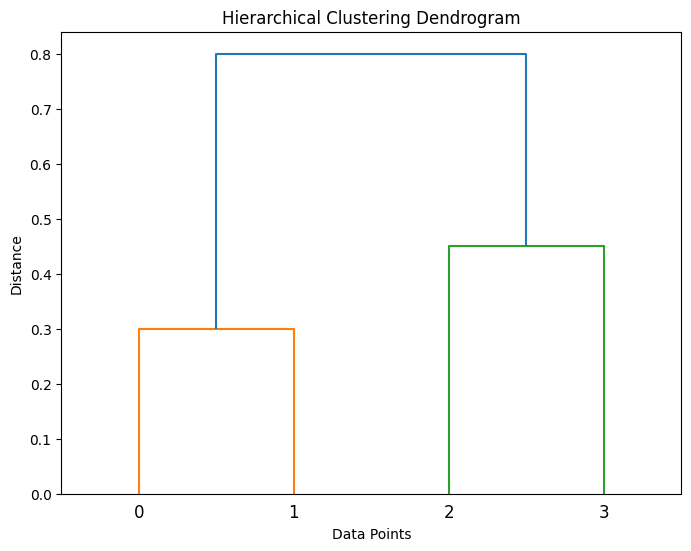

In [259]:
linkage_matrix = linkage(data, method='complete')

plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

(b)

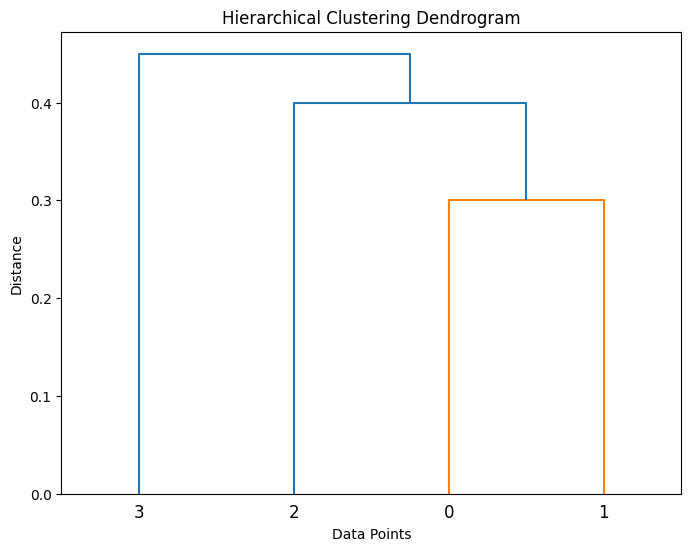

In [260]:
linkage_matrix = linkage(data, method='single')

plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

(c) We have clusters (0,1) and (2,3).

(d) We have clusters (3) and ((0,1),2).

(e) 

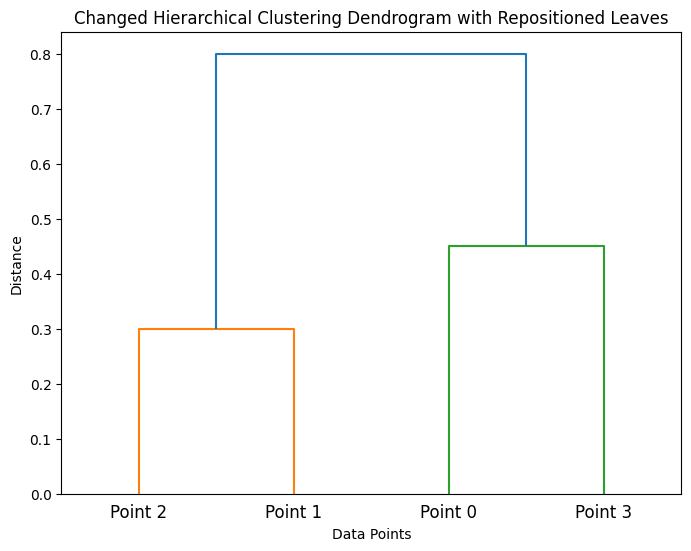

In [263]:
linkage_matrix = linkage(data, method='complete')
original_labels = [f'Point {i}' for i in range(4)]

Changed_labels = original_labels.copy()
Changed_labels[0], Changed_labels[2] = Changed_labels[2], Changed_labels[0]

# Plot the Changed dendrogram with repositioned leaves
plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix, labels=Changed_labels)
plt.title('Changed Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()